In [13]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

Using downloaded and verified file: data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Using downloaded and verified file: data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Using downloaded and verified file: data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4547750.96it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
from torchvision import transforms

mean = (0.2860,)
std = (0.3530,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [16]:
train_ratio = 0.8

train_size = int(len(training_data) * train_ratio)
valid_size = int(len(training_data) - train_size)

print(train_size, valid_size)

48000 12000


In [17]:
from torch.utils.data import random_split

train_dataset, valid_dataset = random_split(training_data, [train_size, valid_size])

In [18]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [10]:
# fashion mnist

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

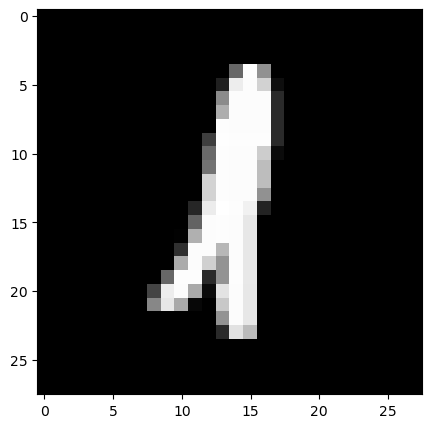

1


In [21]:
import random

idx = random.randint(0,63)
plt.figure(figsize=(5,5))
plt.imshow(images[idx].squeeze(), cmap='gray')
plt.show()
print(labels[idx].item())
# print(labels[idx].item(), labels_map[labels[idx].item()])

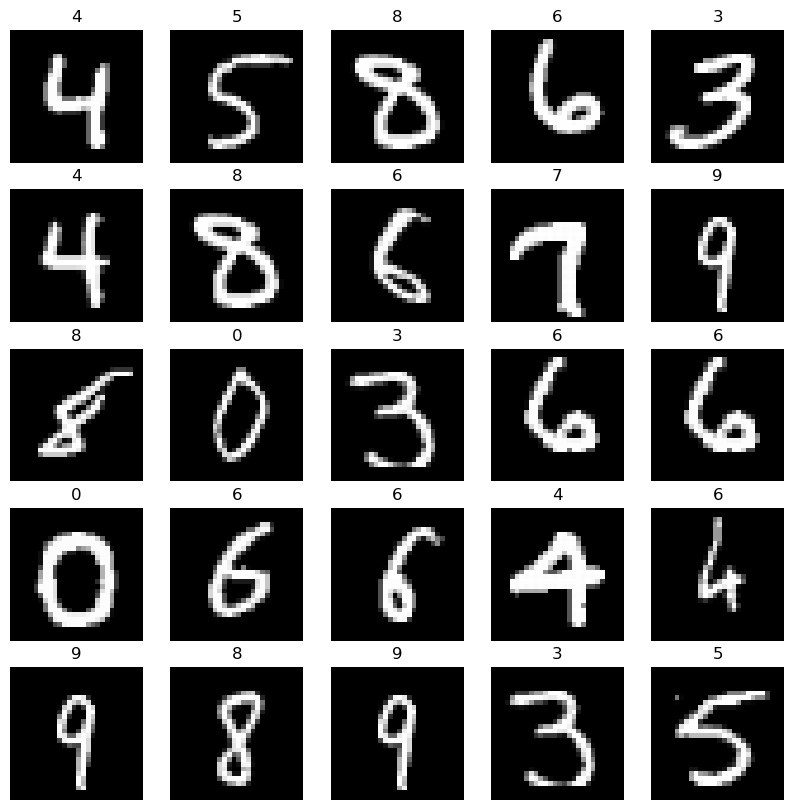

In [22]:
n = 5

fig = plt.figure(figsize=(10,10))
for i in range(n*n):
    idx = random.randint(0,63)
    plt.subplot(n,n,i+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(labels[idx].item())
    plt.axis('off')
plt.show()

In [23]:
from collections import Counter

labels = training_data.targets # train_dataset.targets에 라벨 정보가 저장됨

# 고유한 클래스와 갯수 확인
class_count = Counter(labels.numpy())
num_classes = len(class_count)

print(f'MNIST 데이터셋의 클래스 수: {num_classes}')
print(f'각 클래스별 이미지 개수: {class_count}')

MNIST 데이터셋의 클래스 수: 10
각 클래스별 이미지 개수: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [24]:
from torch import nn
from torch.nn import functional as F

input_node = 28*28
hidden_node1 = 512
hidden_node2 = 256
output_node = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
lr = 0.001

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [26]:
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

In [28]:
def train(dataloader, model, loss_fn, optimizer):
    train_correct = 0
    train_total = 0

    model.train()

    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        y_pred = model(images)

        loss = loss_fn(y_pred, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()

    train_loss_list.append(train_loss)
    train_acc = (train_correct/train_total)*100
    train_acc_list.append(train_acc)

    return train_loss

In [29]:
def valid(dataloader, model, loss_fn):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss_list.append(valid_loss)
    valid_acc = (correct/total)*100
    valid_acc_list.append(valid_acc)

    accuracy = 100 * correct / total
    return valid_loss, accuracy

In [30]:
epochs = 20

for epoch in range(epochs):
    train_loss = train(train_loader, model, loss_fn, optimizer)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}')

    valid_loss, val_acc = valid(valid_loader, model, loss_fn)
    print(f'Validation Loss: {valid_loss/len(valid_loader):.4f}, Validation Accuracy: {val_acc:.2f}%')

Epoch 1/20, Train Loss: 0.2357
Validation Loss: 0.0974, Validation Accuracy: 96.99%
Epoch 2/20, Train Loss: 0.0873
Validation Loss: 0.0602, Validation Accuracy: 98.07%
Epoch 3/20, Train Loss: 0.0573
Validation Loss: 0.0423, Validation Accuracy: 98.76%
Epoch 4/20, Train Loss: 0.0422
Validation Loss: 0.0303, Validation Accuracy: 99.03%
Epoch 5/20, Train Loss: 0.0318
Validation Loss: 0.0199, Validation Accuracy: 99.35%
Epoch 6/20, Train Loss: 0.0241
Validation Loss: 0.0165, Validation Accuracy: 99.47%
Epoch 7/20, Train Loss: 0.0208
Validation Loss: 0.0154, Validation Accuracy: 99.44%
Epoch 8/20, Train Loss: 0.0196
Validation Loss: 0.0112, Validation Accuracy: 99.66%
Epoch 9/20, Train Loss: 0.0163
Validation Loss: 0.0248, Validation Accuracy: 99.12%
Epoch 10/20, Train Loss: 0.0127
Validation Loss: 0.0161, Validation Accuracy: 99.54%
Epoch 11/20, Train Loss: 0.0149
Validation Loss: 0.0112, Validation Accuracy: 99.69%
Epoch 12/20, Train Loss: 0.0111
Validation Loss: 0.0121, Validation Accura

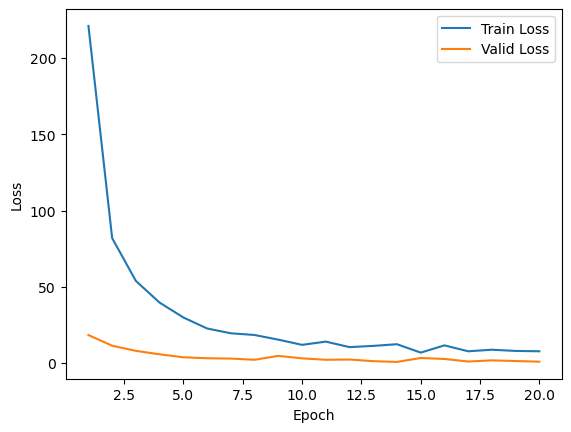

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1,epochs+1), valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

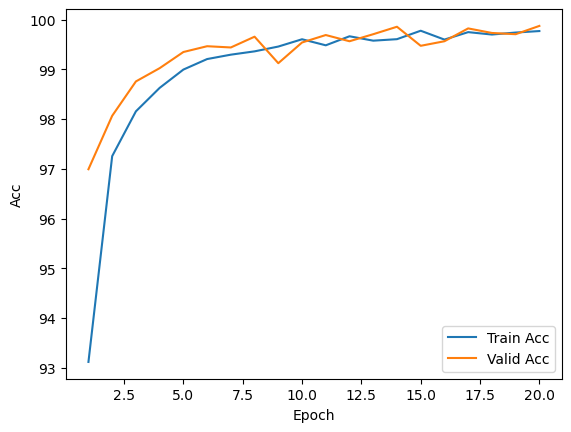

In [32]:
plt.figure()
plt.plot(range(1,epochs+1), train_acc_list, label='Train Acc')
plt.plot(range(1,epochs+1), valid_acc_list, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()